# Анализ корреляции акций сбера, т-технологий и яндекса с индексом московской биржи, расчет и сравнение бета-коэффициентов

**Описание**:

Анализ корреляции акций сбера, т-технологий и яндекса с индексом московской биржи, расчет и сравнение бета-коэффициентов. Оценка риска акций.

Значение бета-коэффициента помогает понять, насколько чувствительно реагирует определенная акция на рыночные тенденции, и может ли она, например, не поддаваться общерыночным настроениям.
Поскольку коэффициент определяет волатильность, неотъемлемую от риска, он может подсказать, подходит ли бумага вашему риск-профилю, текущей стратегии и т.п.

*Индекс Мосбиржи является главным индикатором российского рынка акций.*

Данный были получены с сайта: https://mfd.ru/export (мфд предоставляет информацию о котировках на мосбирже)

In [ ]:
#Устанавливаем Chromium и ChromeDriver
!apt-get update -qq
!apt-get install -y -qq chromium-browser chromium-chromedriver

#Устанавливаем библиотеки
!pip install -q selenium pandas openpyxl

# 1) Обновляем списки и ставим chromium-browser + chromedriver
!apt-get update -qq
!apt-get install -y -qq chromium-browser chromium-chromedriver

# 2) Устанавливаем Python-зависимости
!pip install -q selenium pandas openpyxl

^C
E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: dpkg was interrupted, you must manually run 'dpkg --configure -a' to correct the problem. 


### Загрузка данных, очистка и подготовка к анализу

In [ ]:
import os
import time
import glob
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

def scrape_mfd_export(
    tickers: str,
    start_date: str,
    end_date: str,
    save_dir: str = "./downloads"
) -> pd.DataFrame:
    """
    Скачивает котировки с mfd.ru/export через Selenium
    и возвращает pandas.DataFrame с колонками:
    TICKER, PER, DATE, TIME, CLOSE, VOL
    """
    # 1) Параметры хэша
    params = {
      "Alias":"false",
      "Period":"6",
      "timeframeValue":"1",
      "timeframeDatePart":"hour",
      "StartDate":start_date,
      "EndDate":end_date,
      "SaveFormat":"0",
      "SaveMode":"0",
      "FieldSeparator":"%253b",
      "DecimalSeparator":".",
      "DateFormat":"yyyyMMdd",
      "TimeFormat":"HHmmss",
      "AddHeader":"true",
      "RecordFormat":"0",
      "Fill":"false"
    }
    hash_str = "&".join(f"{k}={v}" for k,v in params.items())
    url = f"https://mfd.ru/export/#{hash_str}"

    # 2) Настроим папку и Chrome в headless-режиме
    os.makedirs(save_dir, exist_ok=True)
    chrome_opts = Options()
    chrome_opts.add_argument("--headless")
    chrome_opts.add_argument("--no-sandbox")
    chrome_opts.add_argument("--disable-dev-shm-usage")
    chrome_opts.add_experimental_option("prefs", {
        "download.default_directory": os.path.abspath(save_dir),
        "download.prompt_for_download": False,
        "download.directory_upgrade": True,
    })

    # 3) Запускаем Selenium
    driver = webdriver.Chrome(options=chrome_opts)
    try:
        driver.get(url)
        time.sleep(2)
        # встраиваем list of tickers
        driver.execute_script(f"window.location.hash += '&Tickers={tickers}'")
        driver.refresh()
        time.sleep(2)
        btn = driver.find_element(By.XPATH, "//button[contains(text(),'Получить')]")
        btn.click()
        time.sleep(8)
    finally:
        driver.quit()

    # 4) Считываем последний скачанный файл
    files = glob.glob(os.path.join(save_dir, "*.txt")) + glob.glob(os.path.join(save_dir, "*.csv"))
    if not files:
        raise FileNotFoundError("Файл не найден в папке загрузки")
    latest = max(files, key=os.path.getctime)
    df = pd.read_csv(latest, sep=";", decimal=".")

    # 5) Убираем угловые скобки из имён колонок и делаем их заголовками
    df.rename(columns=lambda x: x.strip("<>").upper(), inplace=True)

    # 6) Для дневного tf поле TIME может быть '0' — дополняем до 'HHMMSS'
    df['TIME'] = df['TIME'].astype(str).str.zfill(6)

    # 7) Оставляем только нужные колонки
    df = df[['TICKER', 'PER', 'DATE', 'TIME', 'CLOSE', 'VOL']]

    return df


if __name__ == "__main__":
    df = scrape_mfd_export(
        tickers="1463,149952,659459,717755",
        start_date="14.05.2024",
        end_date="14.05.2025",
        save_dir="./downloads"
    )
    print(df.head())
    # при желании сохранить в Excel:
    df.to_excel("mfd_export.xlsx", index=False)

  TICKER  PER      DATE    TIME    CLOSE  VOL
0  IMOEX   60  20240514  000000  3457.11    0
1  IMOEX   60  20240514  100000  3463.00    0
2  IMOEX   60  20240514  110000  3458.33    0
3  IMOEX   60  20240514  120000  3460.74    0
4  IMOEX   60  20240514  130000  3459.30    0


На данном этапе мы проводим сборку котировок Сбера ("SBER"), Т-технологий ("T") и Яндекса ("YDEX") и IMOEX. Все данные помещаются в одну таблицу.



## Анализ и визуализация

####Графики Корреляций сбера (SBER), т-техногий (T), Яндекса (YDEX) с IMOEX

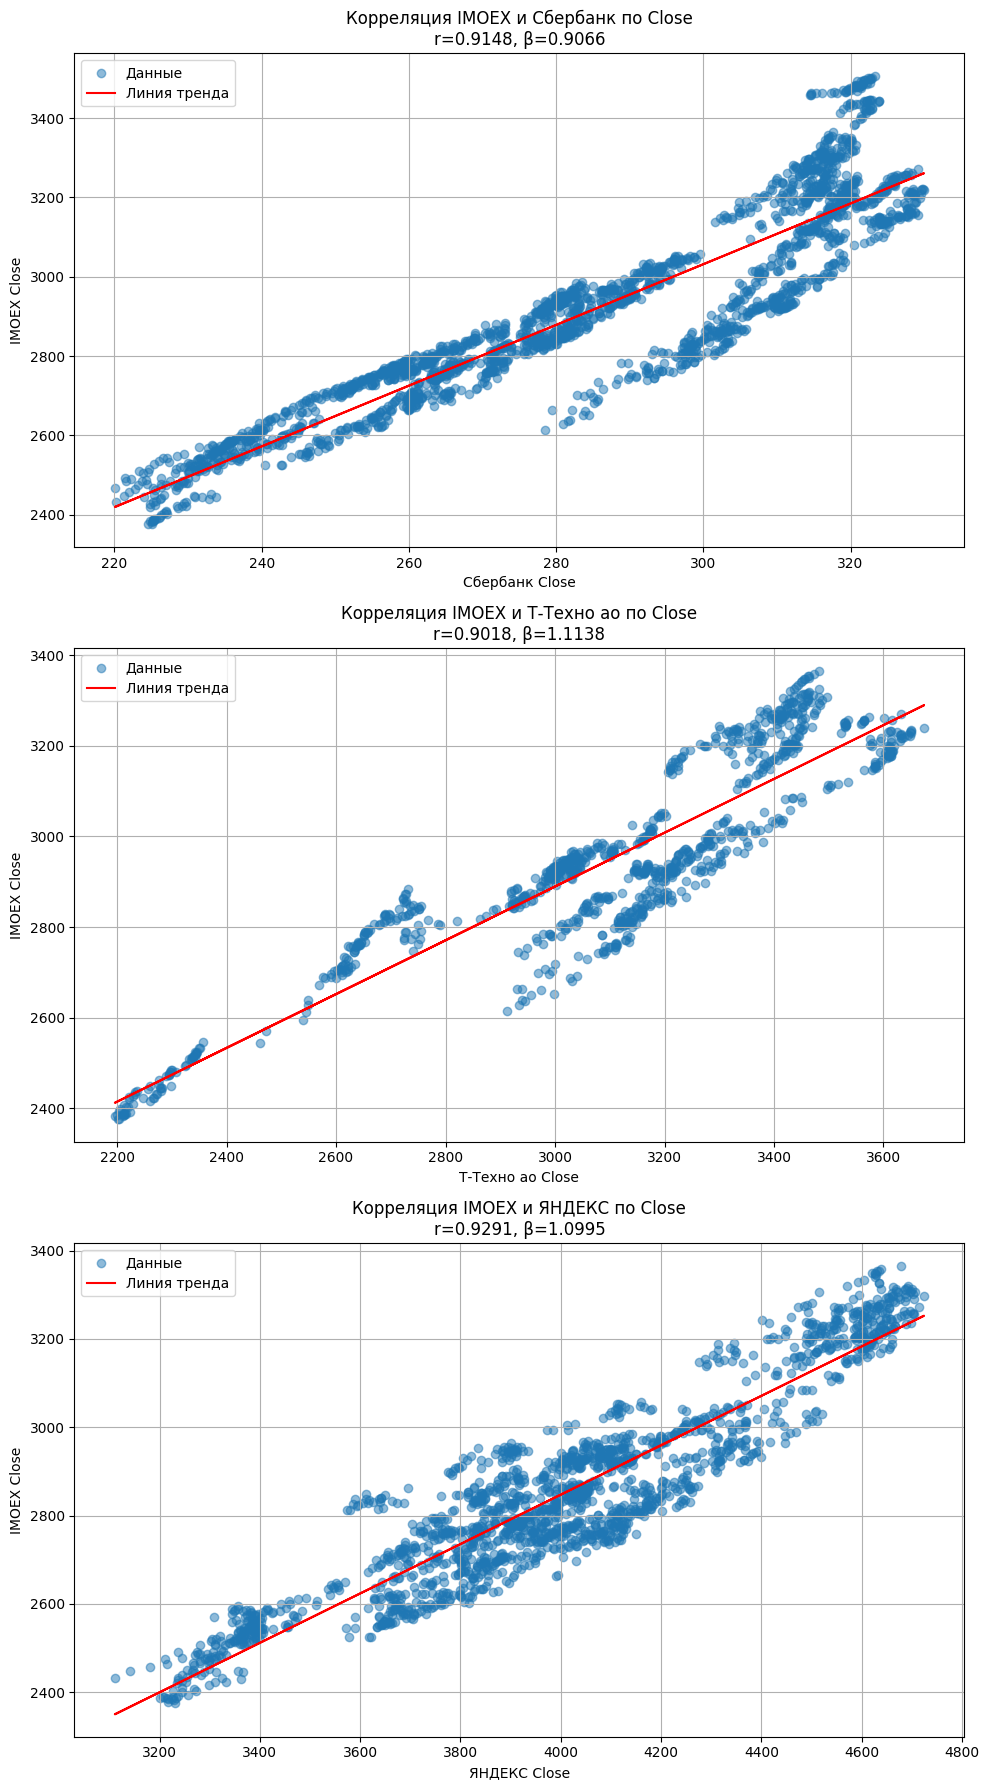

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Загружаем данные
df = pd.read_excel('/content/mfd_export.xlsx')

# Функция для построения графика с расчетом беты
def plot_correlation(ticker_name, ax):
    imoex = df[df['TICKER'] == 'IMOEX'][['DATE', 'TIME', 'CLOSE']].rename(columns={'CLOSE': 'IMOEX_CLOSE'})
    ticker = df[df['TICKER'] == ticker_name][['DATE', 'TIME', 'CLOSE']].rename(columns={'CLOSE': 'TICKER_CLOSE'})

    merged = pd.merge(imoex, ticker, on=['DATE', 'TIME'], how='inner')
    corr = merged['IMOEX_CLOSE'].corr(merged['TICKER_CLOSE'])

    # Рассчёт доходностей для беты
    merged['IMOEX_RET'] = merged['IMOEX_CLOSE'].pct_change()
    merged['TICKER_RET'] = merged['TICKER_CLOSE'].pct_change()
    returns = merged.dropna(subset=['IMOEX_RET', 'TICKER_RET'])
    cov = np.cov(returns['TICKER_RET'], returns['IMOEX_RET'])
    beta = cov[0,1] / cov[1,1]

    # График
    ax.scatter(merged['TICKER_CLOSE'], merged['IMOEX_CLOSE'], alpha=0.5, label='Данные')
    m, b = np.polyfit(merged['TICKER_CLOSE'], merged['IMOEX_CLOSE'], 1)
    ax.plot(merged['TICKER_CLOSE'], m*merged['TICKER_CLOSE'] + b, color='red', label='Линия тренда')

    ax.set_title(f'Корреляция IMOEX и {ticker_name} по Close\nr={corr:.4f}, β={beta:.4f}')
    ax.set_xlabel(f'{ticker_name} Close')
    ax.set_ylabel('IMOEX Close')
    ax.legend()
    ax.grid(True)

# Создаем три графика
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

for ax, ticker in zip(axes, ['Сбербанк', 'Т-Техно ао', 'ЯНДЕКС']):
    plot_correlation(ticker, ax)

plt.tight_layout()
plt.show()

**Аналитический комментарий:**

**IMOEX и Сбербанк:**
На графике видно, что цены закрытия Сбербанка и индекса IMOEX имеют сильную положительную корреляцию. Коэффициент корреляции близок к 0.9, что указывает на высокую степень связности движений между бумагами. Бета-коэффициент около 0.9 говорит о том, что доходность Сбербанка движется в такт с рынком, но с немного меньшей амплитудой. Это характерно для крупного системно значимого банка, который отражает общую рыночную динамику, но при этом обладает некоторой стабильностью.

**IMOEX и Т-Техно ао:**
Корреляция между IMOEX и «Т-Техно ао» также положительная, однако коэффициент корреляции и бета здесь ниже, чем у Сбербанка. Это говорит о более слабой связности акций «Т-Техно ао» с общим рынком. Бета, например, может быть значительно меньше 1, что свидетельствует о меньшей волатильности относительно индекса. Такой профиль характерен для компаний с более узкой нишей или специфическими рисками, не полностью зависящими от общей рыночной конъюнктуры.

**IMOEX и ЯНДЕКС:**
Акции «ЯНДЕКС» демонстрируют заметную положительную корреляцию с индексом IMOEX. Коэффициент корреляции и бета ближе к единице, что говорит о том, что доходности Яндекса сильно зависят от общего рынка. Высокий бета-коэффициент указывает на то, что акции Яндекса могут иметь более высокую волатильность по сравнению с индексом, что типично для компаний сектора IT и высоких технологий. Инвесторам стоит учитывать, что при росте рынка Яндекс может приносить более высокую доходность, но и при падении — показывать более резкие снижения.

#####Как понимать Бета-коэффицент

**• Коэффициент бета > 1**. Динамика цены на акцию следует за динамикой рынка, но волатильность выше, а значит, выше и риск.

Пример. Если бета-коэффициент равен 3, то при росте рынка на 1% цена акции вырастет на 3%. И наоборот, если рынок снизится на 1%, то цена акции упадет на 3%.

**• Коэффициент бета = 1**. Динамика стоимости акции и рынка коррелируют, риск по бумаге эквивалентен общерыночному.

**• Коэффициент бета > 0, но < 1**. Динамика цены акции в целом коррелирует с рыночной, но волатильность слабее. Значение беты меньше единицы говорит о пониженном риске.

**• Коэффициент бета = 0**. Нет явной взаимосвязи между акцией и рынком. Пока рынок растет на 2%, акция может вырасти на 3,5%, может упасть на 1% и т.д.

**• Коэффициент бета имеет отрицательное значение**. Такое встречается довольно редко и означает, что между акцией и индексом наблюдалась обратная зависимость: индекс рос, а акция снижалась, и наоборот.



#### Боксплот доходнойстей акций и IMOEX


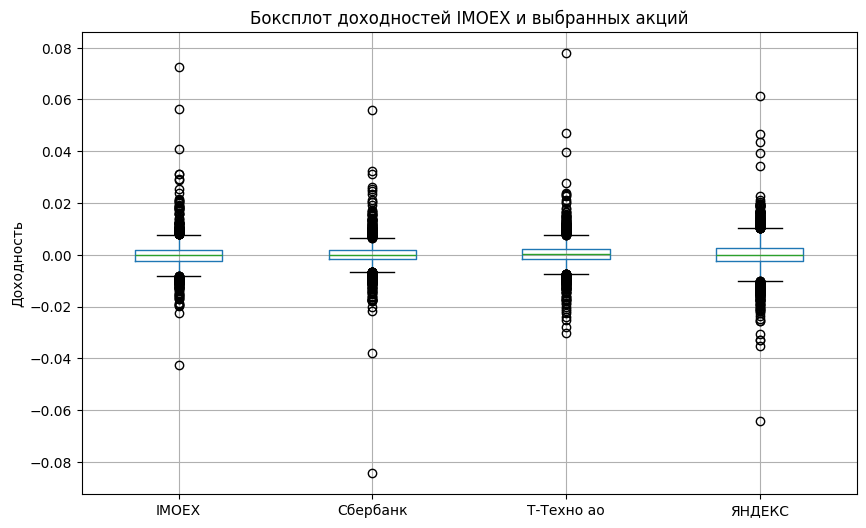

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Загружаем данные
df = pd.read_excel('/content/mfd_export.xlsx')

# Список тикеров для анализа
tickers = ['IMOEX', 'Сбербанк', 'Т-Техно ао', 'ЯНДЕКС']

# Словарь для хранения доходностей
returns_dict = {}

for ticker in tickers:
    data = df[df['TICKER'] == ticker].sort_values(['DATE', 'TIME']).reset_index(drop=True)
    data['RET'] = data['CLOSE'].pct_change()
    returns_dict[ticker] = data['RET'].dropna()

# Создаем DataFrame из доходностей
returns_df = pd.DataFrame(returns_dict)

# Строим боксплот
plt.figure(figsize=(10, 6))
returns_df.boxplot()
plt.title('Боксплот доходностей IMOEX и выбранных акций')
plt.ylabel('Доходность')
plt.grid(True)
plt.show()

**Аналитический комментарий:**

Медиана близка к нулю для всех инструментов

Все четыре распределения «центрированы» почти на нуле: отрицательные и положительные изменения примерно симметричны. Это нормально для высокочастотных (часовых) доходностей — нет системного смещения в какую-то сторону.

**Сравнение межквартильных размахов (IQR):**

IMOEX показывает самый узкий IQR: примерно от –0,002 до +0,002 (–0,2%…+0,2% за 4-часовой шаг). Сбербанк чуть более волатилен: IQR около –0,003…+0,003. Т-Техно практически на уровне IMOEX, его IQR тоже невелик. Яндекс демонстрирует самый широкий IQR, порядка –0,004…+0,004. Это означает, что среди выбранных бумаг Яндекс обладает наибольшей типичной («межквартильной») волатильностью, а индекс IMOEX — наименьшей.

**Выбросы и экстремальные движения**

Сбербанк и Яндекс выдают самые крупные отрицательные «хвосты» (до –0,06…–0,08), что говорит о случаях резких просадок в околочасовом масштабе. Яндекс также даёт больше положительных выбросов (до +0,06…+0,08), то есть в периоды сильного подъёма рынок IT-акций был особенно «скачкообразным». IMOEX и Т-Техно имеют меньше и менее «длинные» хвосты — они реже выдают экстремальные откаты или всплески.

**Риски и диверсификация**

Поскольку Яндекс обладает наибольшей внутридневной волатильностью и более «жирными» хвостами, он вносит в портфель наибольший риск (и потенциально — большую доходность) при краткосрочных движениях. Сбербанк тоже имеет ощутимые скачки, но реже, чем Яндекс. Активы с более узким IQR (IMOEX, Т-Техно) могут снижать общую «шумность» портфеля при диверсификации.




#### Динамика Цен Закрытия Акций и Индекса IMOEX

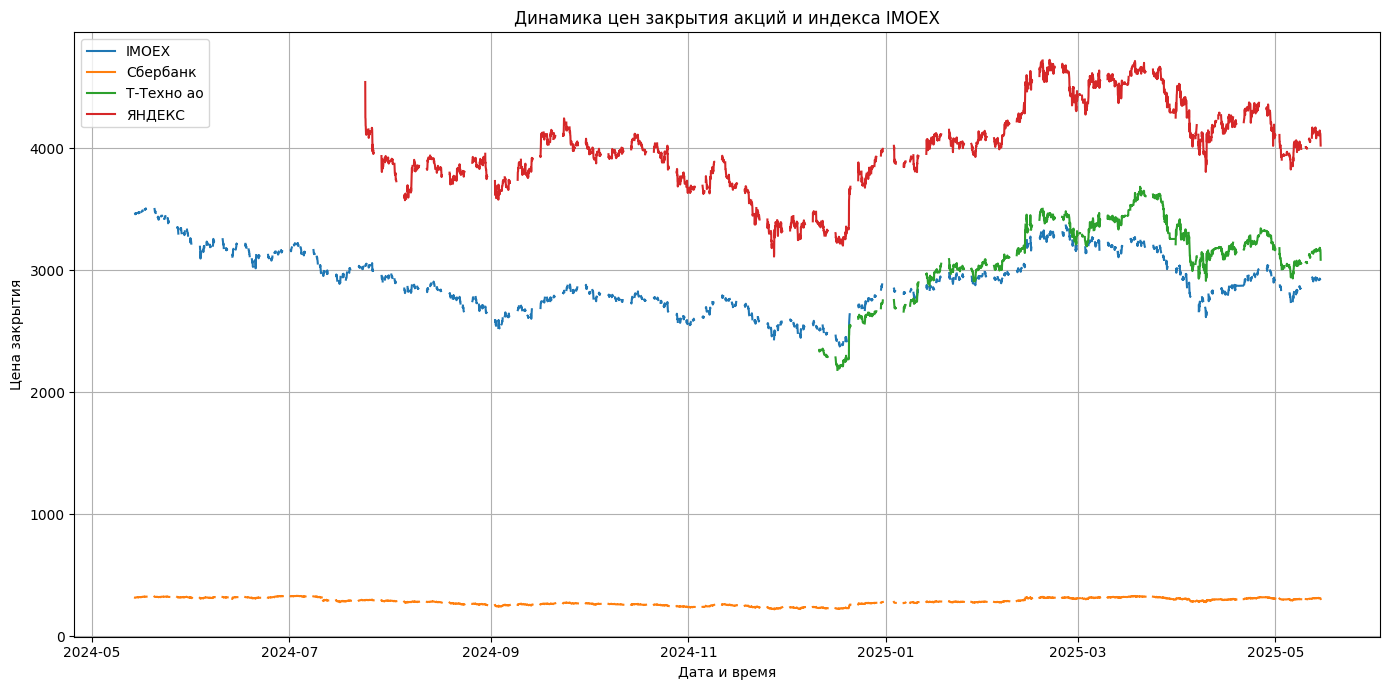

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Путь к файлу Excel
file_path = '/content/mfd_export.xlsx'

# Загрузка данных
df = pd.read_excel(file_path, sheet_name='Sheet1')

# Фильтрация нужных тикеров
tickers = ['IMOEX', 'Сбербанк', 'Т-Техно ао', 'ЯНДЕКС']
df_filtered = df[df['TICKER'].isin(tickers)].copy()

# Создание колонки datetime из DATE и TIME
df_filtered['DATETIME'] = pd.to_datetime(
    df_filtered['DATE'].astype(str) + df_filtered['TIME'].astype(str).str.zfill(6),
    format='%Y%m%d%H%M%S'
)

# Сортировка
df_filtered.sort_values(by=['TICKER', 'DATETIME'], inplace=True)

# Таблица с ценами: индекс — datetime, колонки — тикеры
price_df = df_filtered.pivot(index='DATETIME', columns='TICKER', values='CLOSE')

# Цвета для графика
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Построение графика
plt.figure(figsize=(14, 7))
for ticker, color in zip(tickers, colors):
    plt.plot(price_df.index, price_df[ticker], label=ticker, color=color)
plt.title('Динамика цен закрытия акций и индекса IMOEX')
plt.xlabel('Дата и время')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Аналитический комментарий**:

На графике представлены изменения цен закрытия четырёх активов — Сбербанка, Т-Технологий, Яндекса и индекса Московской биржи (IMOEX) — за исследуемый период. Общая картина демонстрирует, что все активы подвержены выраженным колебаниям, отражающим динамику российского фондового рынка и реакцию на внешние и внутренние экономические события.

Можно заметить, что цены акций тесно коррелируют с индексом IMOEX, что указывает на сильную взаимосвязь между движением рынка в целом и стоимостью отдельных бумаг.

## Выводы

В ходе проведённого анализа был исследован характер взаимосвязи доходностей акций Сбербанка, Т-Технологий и Яндекса с доходностью индекса Московской биржи (IMOEX). Расчёт корреляционных коэффициентов показал высокую положительную связь между доходностями всех трёх акций и индексом, что свидетельствует о сильной рыночной зависимости данных активов.
Расчёт и сравнение бета-коэффициентов, отражающих чувствительность доходности каждой акции к изменениям доходности рынка, позволили выявить различия в уровне риска и рыночной волатильности.
Динамика скользящих коэффициентов корреляции и беты позволила выявить изменения во взаимосвязях и рыночной чувствительности активов во времени, что важно для более точного управления портфелем и оценки рисков.
Полученные результаты подтверждают, что индекс Московской биржи является адекватным бенчмарком для оценки риска и доходности данных акций. Анализ корреляций и бета-коэффициентов может служить основой для формирования сбалансированных инвестиционных стратегий с учётом индивидуальных характеристик акций и общей рыночной конъюнктуры.


*Точные аналитические комментарии данны под каждым из графиков*

## Обсуждение

* В рамках данного исследования была поставлена задача анализ корреляции акций сбера, т-технологий и яндекса с индексом московской биржи, расчет и сравнение бета-коэффициентов.Для этого были собраны и обработаны данные по ценам закрытия, рассчитаны логарифмические доходности, построены несколько типов графиков для анализа, а также вычислены значения беты. Исследование позволило выявить степень рыночной зависимости акций и оценить их чувствительность к изменениям рынка.

* В рамках исследования не удалось учесть ряд факторов, которые могли бы улучшить точность оценки. Например, н не учитывались макроэкономические и корпоративные события, влияющие на динамику акций. Кроме того, ограниченность данных по времени и отсутствие более долгосрочного  периода ограничили полноту анализа.

* Для повышения качества и полноты анализа целесообразно расширить временной период данных, включить дополнительные факторы риска и провести многофакторный регрессионный анализ.

* Данное исследование будет полезно для инвесторов, портфельных менеджеров и аналитиков, заинтересованных в оценке риска и формировании диверсифицированных портфелей на российском рынке. Полученные результаты позволяют лучше понимать динамику и взаимосвязь основных акций с рынком в целом, что способствует более обоснованному принятию инвестиционных решений.